# README: CELP Compression Algorithm Evolution

このプロジェクトでは、CELP（Code Excited Linear Prediction）音声圧縮アルゴリズムの実装を通じて、技術的な進化を体験します。  
各プログラムファイルの主な特徴と改善点を以下に説明します。
このプロジェクトでは、CELP（Code Excited Linear Prediction）音声圧縮アルゴリズムの実装を通じて、技術的な進化を体験します。  
各プログラムファイルの主な特徴と改善点を以下に説明します。

## プログラムへのリンク
- [1. CELP.py](#celppy-program)
- [2. CELP2.py](#celp2py-program)
- [3. CELP3.py](#celp3py-program)
- [4. CELP4.py](#celp4py-program)

## 1. CELP.py
- **概要**: 最も基本的なCELPアルゴリズムの実装。
- **特徴**: ランダムなコードブックを用い、単一フレームの符号化と復号化を実行します。
- **目的**: CELPアルゴリズムの基本概念と実装手法を理解するための出発点。

## 2. CELP2.py
- **概要**: スパースコードブックを導入し、符号化精度を向上。
- **特徴**: 
  - スパースな励振信号を生成し、効率的に符号化。
  - フレームサイズを短縮し、よりリアルタイム性の高い符号化を実現。
- **目的**: 励振信号のスパース性を利用した符号化の精度向上を学習。

## 3. CELP3.py
- **概要**: 感覚重み付けフィルタを追加し、音質を改善。
- **特徴**: 
  - LPC係数に感覚重み付けを適用。
  - LPC次数を16に増加させ、周波数特性の精度を向上。
  - コードブックサイズを512に拡大し、選択肢を増加。
- **目的**: 感覚的により自然な音声復元を実現する手法を学習。

## 4. CELP4.py
- **概要**: オーバーラップフレーム処理を導入し、符号化と復号化の滑らかさを向上。
- **特徴**: 
  - フレームオーバーラップを追加し、フレーム間の不連続性を軽減。
  - フィルタの初期条件設定を導入し、フレーム処理間の安定性を向上。
  - 再合成時に加算処理を行い、全体の再現精度を向上。
- **目的**: 実運用に近い高精度なCELPアルゴリズムを実現。

---

**本プロジェクトの目的**  
この4つのプログラムを通じて、基本から高度な実装まで、CELPアルゴリズムの進化を体験し、音声符号化の理論と実践的技術を体系的に学ぶことを目指します。


### CELP.py Program

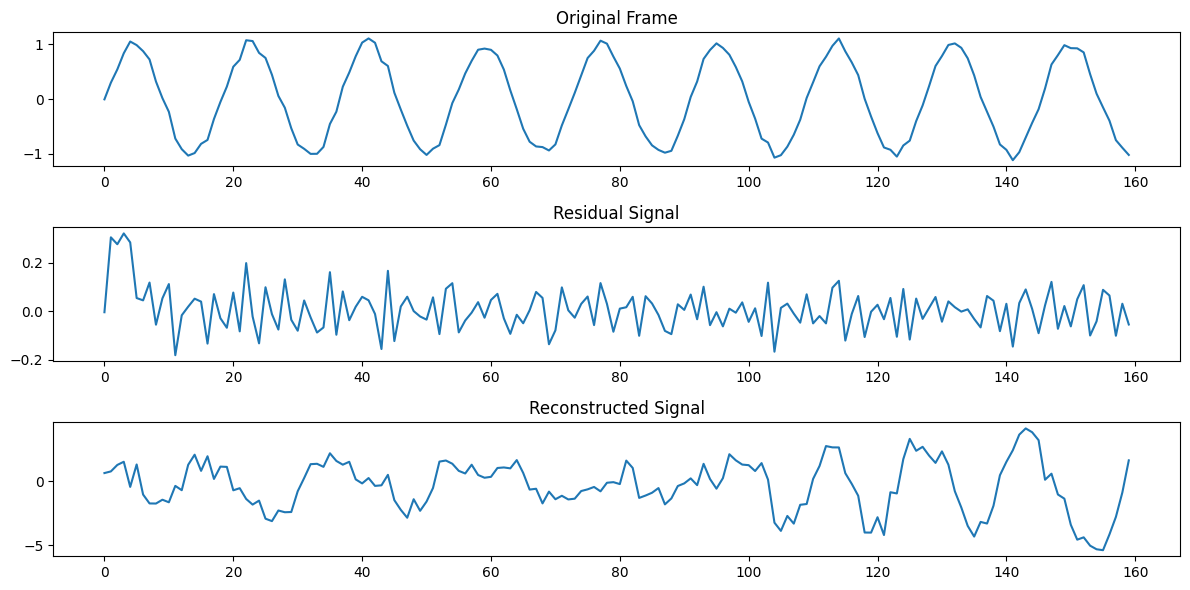

In [1]:
%matplotlib inline
import numpy as np
from scipy.signal import lfilter
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt

# サンプルデータの生成（正弦波 + ノイズ）
fs = 8000  # サンプリング周波数
t = np.linspace(0, 1, fs)
signal = np.sin(2 * np.pi * 440 * t) + 0.05 * np.random.randn(len(t))

# パラメータ
frame_size = 160  # フレーム長（20ms）
lpc_order = 10  # LPC係数の次数

# フレーム分割
def frame_signal(signal, frame_size):
    num_frames = len(signal) // frame_size
    frames = signal[:num_frames * frame_size].reshape(num_frames, frame_size)
    return frames

frames = frame_signal(signal, frame_size)

# LPC係数の計算
def compute_lpc(frame, order):
    autocorr = np.correlate(frame, frame, mode='full')
    autocorr = autocorr[len(autocorr)//2:]  # 自己相関
    r = autocorr[:order+1]
    R = toeplitz(r[:-1])  # Toeplitz行列
    a = np.linalg.solve(R, -r[1:])  # LPC係数
    error = r[0] + np.dot(r[1:], a)  # 残差エネルギー
    return np.concatenate(([1], a)), error

# コードブックの生成
def generate_codebook(size, length):
    return np.random.randn(size, length)  # ランダムコードブック

codebook_size = 64
codebook = generate_codebook(codebook_size, frame_size)

# CELPコーディング（単一フレームの例）
frame = frames[0]  # 最初のフレームを選択

# LPC解析
lpc_coeffs, _ = compute_lpc(frame, lpc_order)

# LPCフィルタによる残差計算
residual = lfilter(lpc_coeffs, [1], frame)

# コードブック検索
best_index = None
min_error = float('inf')
best_excitation = None

for i, excitation in enumerate(codebook):
    # フィルタを通して合成信号を生成
    synthesized = lfilter([1], lpc_coeffs, excitation)
    error = np.sum((residual - synthesized) ** 2)  # 誤差エネルギー
    if error < min_error:
        min_error = error
        best_index = i
        best_excitation = excitation

# 再合成信号
reconstructed = lfilter([1], lpc_coeffs, best_excitation)

# 結果をプロット
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.title("Original Frame")
plt.plot(frame)
plt.subplot(3, 1, 2)
plt.title("Residual Signal")
plt.plot(residual)
plt.subplot(3, 1, 3)
plt.title("Reconstructed Signal")
plt.plot(reconstructed)
plt.tight_layout()
plt.show()


### CELP2.py Program

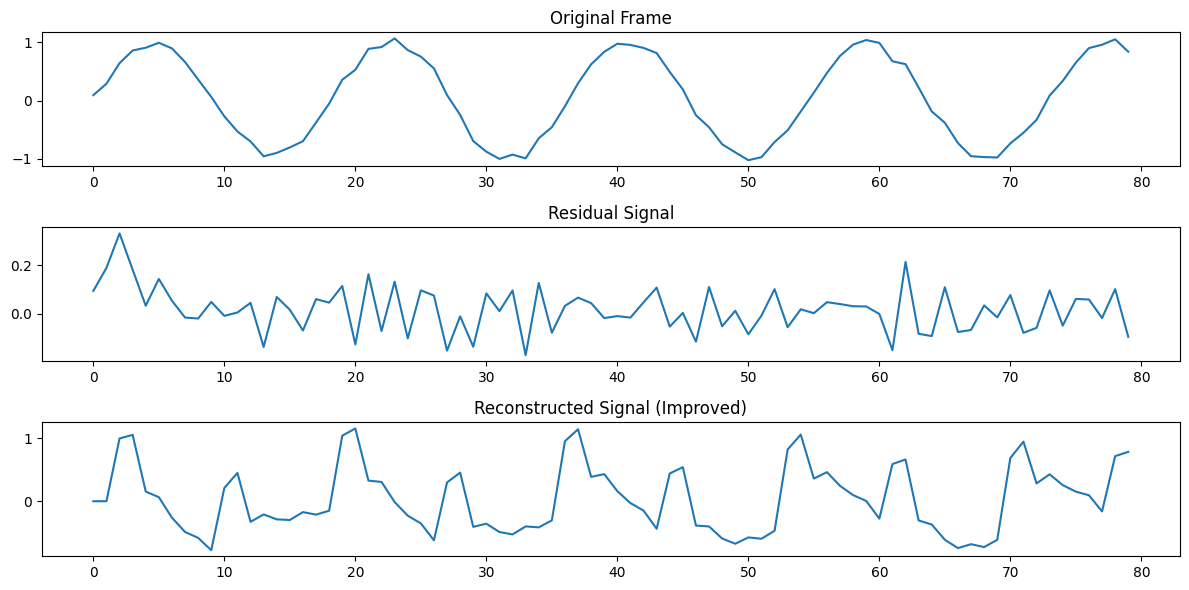

In [2]:
import numpy as np
from scipy.signal import lfilter
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt

# サンプルデータの生成（正弦波 + ノイズ）
fs = 8000  # サンプリング周波数
t = np.linspace(0, 1, fs)
signal = np.sin(2 * np.pi * 440 * t) + 0.05 * np.random.randn(len(t))

# パラメータ
frame_size = 80  # フレーム長（10ms）
lpc_order = 10  # LPC係数の次数

# フレーム分割
def frame_signal(signal, frame_size):
    num_frames = len(signal) // frame_size
    frames = signal[:num_frames * frame_size].reshape(num_frames, frame_size)
    return frames

frames = frame_signal(signal, frame_size)

# LPC係数の計算
def compute_lpc(frame, order):
    autocorr = np.correlate(frame, frame, mode='full')
    autocorr = autocorr[len(autocorr)//2:]  # 自己相関
    r = autocorr[:order+1]
    R = toeplitz(r[:-1])  # Toeplitz行列
    a = np.linalg.solve(R, -r[1:])  # LPC係数
    error = r[0] + np.dot(r[1:], a)  # 残差エネルギー
    return np.concatenate(([1], a)), error

# スパースコードブックの生成
def generate_sparse_codebook(size, length, non_zero_count):
    codebook = []
    for _ in range(size):
        vector = np.zeros(length)
        positions = np.random.choice(length, non_zero_count, replace=False)  # 非ゼロ要素の位置をランダムに選択
        signs = np.random.choice([-1, 1], non_zero_count)  # 非ゼロ要素の符号をランダムに選択
        for pos, sign in zip(positions, signs):
            vector[pos] = sign
        codebook.append(vector)
    return np.array(codebook)

# フレーム全体にスパースベクトルを周期的に展開
def expand_to_frame(sparse_vector, frame_size):
    repeated_vector = np.tile(sparse_vector, (frame_size // len(sparse_vector) + 1))  # 繰り返し
    return repeated_vector[:frame_size]  # フレームサイズに切り詰める

# スパースコードブックの生成
codebook_size = 256  # コードブックサイズ
codebook_length = 17  # スパースベクトルの長さ
non_zero_count = 4  # 非ゼロ要素の数
sparse_codebook = generate_sparse_codebook(codebook_size, codebook_length, non_zero_count)

# CELPコーディング（1フレームの例）
frame = frames[0]  # 最初のフレームを選択

# LPC解析
lpc_coeffs, _ = compute_lpc(frame, lpc_order)

# LPCフィルタによる残差計算
residual = lfilter(lpc_coeffs, [1], frame)

# コードブック検索
min_error = float('inf')
best_index = None
best_excitation = None

# コードブック検索と最適励振信号の決定
for i, sparse_vector in enumerate(sparse_codebook):
    expanded_vector = expand_to_frame(sparse_vector, frame_size)  # フレーム全体に展開
    synthesized = lfilter([1], lpc_coeffs, expanded_vector)  # フィルタを通して合成信号を生成
    error = np.sum((residual - synthesized) ** 2)  # 誤差エネルギー
    if error < min_error:
        min_error = error
        best_index = i
        best_excitation = expanded_vector

# 再合成信号
reconstructed = lfilter([1], lpc_coeffs, best_excitation)

# 結果をプロット
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.title("Original Frame")
plt.plot(frame)
plt.subplot(3, 1, 2)
plt.title("Residual Signal")
plt.plot(residual)
plt.subplot(3, 1, 3)
plt.title("Reconstructed Signal (Improved)")
plt.plot(reconstructed)
plt.tight_layout()
plt.show()


### 3. CELP3.py Program

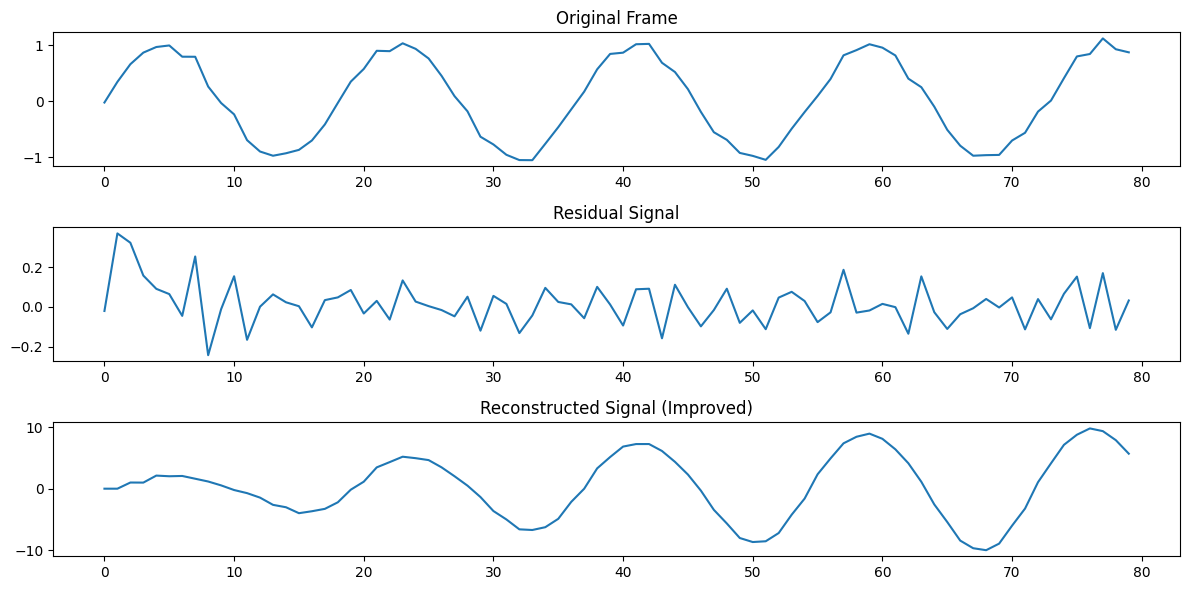

In [3]:
import numpy as np
from scipy.signal import lfilter
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt

# サンプルデータの生成（正弦波 + ノイズ）
fs = 8000  # サンプリング周波数
t = np.linspace(0, 1, fs)
signal = np.sin(2 * np.pi * 440 * t) + 0.05 * np.random.randn(len(t))

# パラメータ
frame_size = 80  # フレーム長（10ms）
lpc_order = 16  # LPC係数の次数（精度向上）
gamma1 = 0.9  # 感覚重み付けフィルタパラメータ
gamma2 = 0.6

# フレーム分割
def frame_signal(signal, frame_size):
    num_frames = len(signal) // frame_size
    frames = signal[:num_frames * frame_size].reshape(num_frames, frame_size)
    return frames

frames = frame_signal(signal, frame_size)

# LPC係数の計算
def compute_lpc(frame, order):
    autocorr = np.correlate(frame, frame, mode='full')
    autocorr = autocorr[len(autocorr)//2:]  # 自己相関
    r = autocorr[:order+1]
    R = toeplitz(r[:-1])  # Toeplitz行列
    a = np.linalg.solve(R, -r[1:])  # LPC係数
    error = r[0] + np.dot(r[1:], a)  # 残差エネルギー
    return np.concatenate(([1], a)), error

# 感覚重み付けフィルタの適用
def perceptual_filter(lpc_coeffs, gamma1, gamma2):
    weighted_coeffs = [(1 - gamma1) * coeff for coeff in lpc_coeffs]
    return [1] + weighted_coeffs

# スパースコードブックの生成
def generate_sparse_codebook(size, length, non_zero_count):
    codebook = []
    for _ in range(size):
        vector = np.zeros(length)
        positions = np.random.choice(length, non_zero_count, replace=False)  # 非ゼロ要素の位置をランダムに選択
        signs = np.random.choice([-1, 1], non_zero_count)  # 非ゼロ要素の符号をランダムに選択
        for pos, sign in zip(positions, signs):
            vector[pos] = sign
        codebook.append(vector)
    return np.array(codebook)

# フレーム全体にスパースベクトルを周期的に展開
def expand_to_frame(sparse_vector, frame_size):
    repeated_vector = np.tile(sparse_vector, (frame_size // len(sparse_vector) + 1))  # 繰り返し
    return repeated_vector[:frame_size]  # フレームサイズに切り詰める

# スパースコードブックの生成
codebook_size = 512  # コードブックサイズを拡大
codebook_length = 17  # スパースベクトルの長さ
non_zero_count = 4  # 非ゼロ要素の数
sparse_codebook = generate_sparse_codebook(codebook_size, codebook_length, non_zero_count)

# CELPコーディング（1フレームの例）
frame = frames[0]  # 最初のフレームを選択

# LPC解析
lpc_coeffs, _ = compute_lpc(frame, lpc_order)
weighted_coeffs = perceptual_filter(lpc_coeffs, gamma1, gamma2)

# LPCフィルタによる残差計算
residual = lfilter(lpc_coeffs, [1], frame)

# コードブック検索
min_error = float('inf')
best_index = None
best_excitation = None

# コードブック検索と最適励振信号の決定
for i, sparse_vector in enumerate(sparse_codebook):
    expanded_vector = expand_to_frame(sparse_vector, frame_size)  # フレーム全体に展開
    synthesized = lfilter(weighted_coeffs, [1], expanded_vector)  # フィルタを通して合成信号を生成
    error = np.sum((residual - synthesized) ** 2)  # 誤差エネルギー
    if error < min_error:
        min_error = error
        best_index = i
        best_excitation = expanded_vector

# 再合成信号
reconstructed = lfilter([1], lpc_coeffs, best_excitation)

# 結果をプロット
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.title("Original Frame")
plt.plot(frame)
plt.subplot(3, 1, 2)
plt.title("Residual Signal")
plt.plot(residual)
plt.subplot(3, 1, 3)
plt.title("Reconstructed Signal (Improved)")
plt.plot(reconstructed)
plt.tight_layout()
plt.show()



### 4. CELP4.py Program

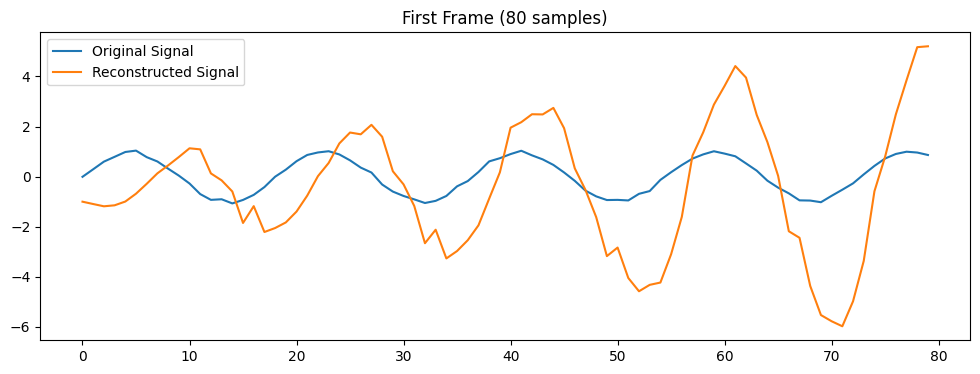

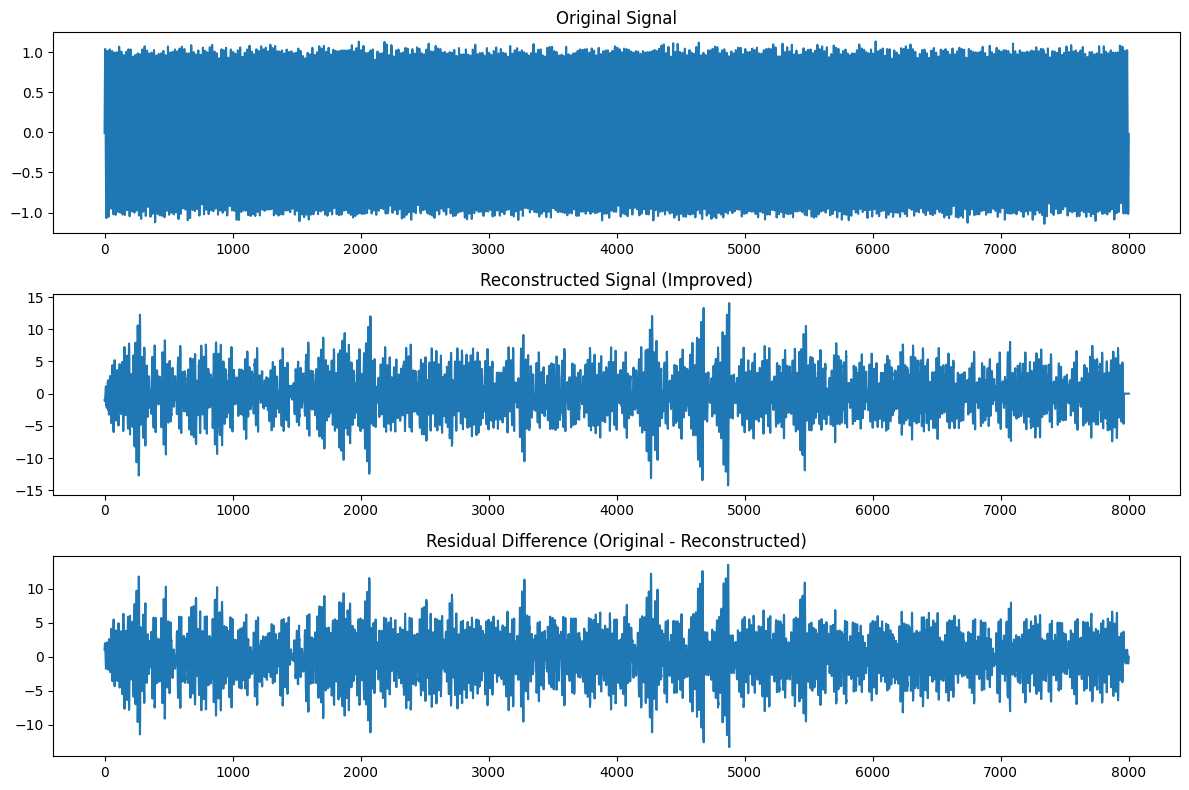

In [4]:
import numpy as np
from scipy.signal import lfilter, lfilter_zi
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt

# サンプルデータの生成（正弦波 + ノイズ）
fs = 8000  # サンプリング周波数
t = np.linspace(0, 1, fs)
signal = np.sin(2 * np.pi * 440 * t) + 0.05 * np.random.randn(len(t))

# パラメータ
frame_size = 80  # フレーム長（10ms）
overlap = 40  # フレームオーバーラップ（50%）
lpc_order = 16  # LPC係数の次数（精度向上）
gamma1 = 0.9  # 感覚重み付けフィルタパラメータ
gamma2 = 0.6

# フレーム分割（オーバーラップあり）
def frame_signal_with_overlap(signal, frame_size, overlap):
    step = frame_size - overlap
    num_frames = (len(signal) - overlap) // step
    frames = np.array([signal[i*step:i*step+frame_size] for i in range(num_frames)])
    return frames

frames = frame_signal_with_overlap(signal, frame_size, overlap)

# LPC係数の計算
def compute_lpc(frame, order):
    autocorr = np.correlate(frame, frame, mode='full')
    autocorr = autocorr[len(autocorr)//2:]  # 自己相関
    r = autocorr[:order+1]
    R = toeplitz(r[:-1])  # Toeplitz行列
    a = np.linalg.solve(R, -r[1:])  # LPC係数
    error = r[0] + np.dot(r[1:], a)  # 残差エネルギー
    return np.concatenate(([1], a)), error

# 感覚重み付けフィルタの適用
def perceptual_filter(lpc_coeffs, gamma1, gamma2):
    weighted_coeffs = [(1 - gamma1) * coeff for coeff in lpc_coeffs]
    return [1] + weighted_coeffs

# スパースコードブックの生成
def generate_sparse_codebook(size, length, non_zero_count):
    codebook = []
    for _ in range(size):
        vector = np.zeros(length)
        positions = np.random.choice(length, non_zero_count, replace=False)  # 非ゼロ要素の位置をランダムに選択
        signs = np.random.choice([-1, 1], non_zero_count)  # 非ゼロ要素の符号をランダムに選択
        for pos, sign in zip(positions, signs):
            vector[pos] = sign
        codebook.append(vector)
    return np.array(codebook)

# フレーム全体にスパースベクトルを周期的に展開
def expand_to_frame(sparse_vector, frame_size):
    repeated_vector = np.tile(sparse_vector, (frame_size // len(sparse_vector) + 1))  # 繰り返し
    return repeated_vector[:frame_size]  # フレームサイズに切り詰める

# フィルタの初期条件を設定
def filter_with_initial_conditions(lpc_coeffs, frame, zi=None):
    if zi is None:
        zi = lfilter_zi([1], lpc_coeffs) * frame[0]  # フレームの最初のサンプルに基づいて設定
    filtered, zf = lfilter(lpc_coeffs, [1], frame, zi=zi)  # フィルタ処理
    return filtered, zf

# スパースコードブックの生成
codebook_size = 512  # コードブックサイズを拡大
codebook_length = 17  # スパースベクトルの長さ
non_zero_count = 4  # 非ゼロ要素の数
sparse_codebook = generate_sparse_codebook(codebook_size, codebook_length, non_zero_count)

# CELPコーディング
zi = None  # 初期条件
reconstructed_signal = np.zeros(len(signal))  # 再合成信号
step = frame_size - overlap

# フレームごとの符号化と再合成
for i, frame_start in enumerate(range(0, len(signal) - frame_size, step)):
    frame = signal[frame_start:frame_start + frame_size]

    # LPC解析
    lpc_coeffs, _ = compute_lpc(frame, lpc_order)
    weighted_coeffs = perceptual_filter(lpc_coeffs, gamma1, gamma2)

    # 残差計算
    residual, zi = filter_with_initial_conditions(lpc_coeffs, frame, zi)

    # コードブック検索
    min_error = float('inf')
    best_excitation = None

    for sparse_vector in sparse_codebook:
        expanded_vector = expand_to_frame(sparse_vector, frame_size)  # フレーム全体に展開
        synthesized = lfilter(weighted_coeffs, [1], expanded_vector)  # フィルタを通して合成信号を生成
        error = np.sum((residual - synthesized) ** 2)  # 誤差エネルギー
        if error < min_error:
            min_error = error
            best_excitation = expanded_vector

    # 再合成
    reconstructed_frame = lfilter([1], lpc_coeffs, best_excitation)
    reconstructed_signal[frame_start:frame_start + frame_size] += reconstructed_frame  # フレームを加算
    zi = None  # フレーム切り替え時に初期条件をリセット


# フレーム単位でプロット（例：最初のフレーム）
plt.figure(figsize=(12, 4))
plt.title("First Frame (80 samples)")
plt.plot(signal[:80], label="Original Signal")
plt.plot(reconstructed_signal[:80], label="Reconstructed Signal")
plt.legend()
plt.show()


# 結果をプロット
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.title("Original Signal")
plt.plot(signal)
plt.subplot(3, 1, 2)
plt.title("Reconstructed Signal (Improved)")
plt.plot(reconstructed_signal)
plt.subplot(3, 1, 3)
plt.title("Residual Difference (Original - Reconstructed)")
plt.plot(signal - reconstructed_signal)
plt.tight_layout()
plt.show()
